In [16]:
from imports import *

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
warnings.filterwarnings("ignore")

In [19]:
%matplotlib widget

#### Load data, split and create dataset

In [20]:
from utils import series_to_array
data = process_file()
timeseries = series_to_array(data)

In [21]:
train_size = int(len(timeseries) * 0.85)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [22]:
len(train)

414

#### Defining grid search

In [9]:
from model import train_model, evaluate_model_last_prediction, LSTMModel


In [12]:
from utils import scale_data
from time import time

def evaluate(hyper_params):

    X_train, y_train = create_dataset(train, lookback=hyper_params['lookback'])
    X_test, y_test = create_dataset(test, lookback=hyper_params['lookback'])    
    
    X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)
    
    # print("X_train", X_train.shape, "y_train", y_train.shape)
    # print("X_test",X_test.shape, "y_test",y_test.shape)
    
    model = LSTMModel(input_size=hyper_params['lookback'], hidden_size=hyper_params['hidden_size'], 
                      num_layers=hyper_params['num_layers'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(
        data.TensorDataset(X_train, y_train), shuffle=True, batch_size=hyper_params['batch_size'], 
        drop_last=True
    )
    t0 = time()    
    # Train the model
    train_losses, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=hyper_params['n_epochs'], 
                                           print_interval=50, seed=42)
    train_time = time() - t0
    # Evaluate the model
    train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(
        model, X_train, y_train, X_test, y_test, scaler_y, loss_fn
    )
    
    final_train_loss = train_loss[-1]
    final_test_loss = test_loss[-1]

    result = hyper_params.copy()
    metrics = {
        'final_train_loss': final_train_loss,
        'final_test_loss': final_test_loss,
        'train_losses': train_losses,
        'train_time': train_time
    }
    result.update(metrics)
    return result
    

In [13]:
from random import Random
from sklearn.model_selection import ParameterGrid

# Define grid search hyperparameters
grid = ParameterGrid({
    'lookback': [7, 14, 28],
    'output_size': [1],
    'n_epochs': [300, 1000, 3000],
    'batch_size' : [14],
    'hidden_size': [15, 25, 50],
    'num_layers': [1, 2, 3],
    'lr': [0.0001, 0.0003]
})

grid = list(grid)
Random(42).shuffle(grid)
grid.sort(key=lambda x: x['n_epochs'])

In [14]:
print("Number of experiments", len(grid))

Number of experiments 162


In [ ]:
import pickle as pkl
from tqdm.auto import tqdm

experiments = []
for hyper_params in tqdm(grid):
    experiments.append(evaluate(hyper_params))
    
    with open('experiments.pkl', 'wb') as f:
        pkl.dump(experiments, f)


In [20]:
!mv experiments.pkl experiments_bck1_big.pkl

### Analisis Grid Search

In [21]:
import pickle
with open('experiments_bck.pkl', 'rb') as f:
    experiments = pkl.load(f)

In [22]:
exps_df = pd.DataFrame(experiments)

Text(0.5, 1.0, 'Train vs Test losses')

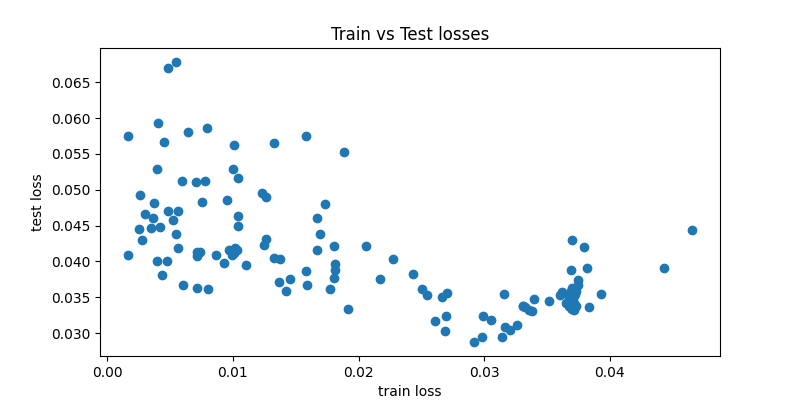

In [25]:
plt.figure(figsize=(8,4))
plt.scatter(exps_df.final_train_loss, exps_df.final_test_loss)
plt.xlabel('train loss')
plt.ylabel('test loss');
plt.title("Train vs Test losses")

In [23]:
hyper_params = 'batch_size hidden_size lookback lr n_epochs num_layers'.split()
metrics = 'final_train_loss final_test_loss train_time'.split()

In [24]:
from collections import defaultdict

def hash_dict(d):
    return hash(str(sorted(d.items())))

def exp_plot(hyper_param, metric, color_col):
    plt.figure(figsize=(15,3))
    
    plot_by_conf = defaultdict(list)
    for doc in exps_df.to_dict(orient='records'):
        hp_val = doc.pop(hyper_param)
        other_hps = {k: v for k, v in doc.items() if k in hyper_params}
        
        doc_to_append = {hyper_param: hp_val, metric: doc[metric]}
        if color_col != hyper_param:
            doc_to_append[color_col] = doc[color_col]
            
        plot_by_conf[hash_dict(other_hps)].append(doc_to_append)

    scatter_x = []
    scatter_y = []
    scatter_c = []
    
    for data in sorted(plot_by_conf.values(), key=lambda data: pd.DataFrame(data)[metric].min())[:10]:
        df = pd.DataFrame(data).set_index(hyper_param, drop=False).sort_index()
        df[metric].plot(linestyle='--', color='k', alpha=0.25)
        scatter_x.extend(df.index)
        scatter_y.extend(df[metric])
        scatter_c.extend(df[color_col])
        
    plt.scatter(scatter_x, scatter_y, c=scatter_c, alpha=0.45)
    plt.colorbar()
    plt.grid()
        

In [25]:
from IPython.display import display, Markdown

display_markdown = lambda x: display(Markdown(x))
def do():
    for hyper_param in hyper_params:
        # no interesan los que tienen un solo valor
        unique_vals = sorted(exps_df[hyper_param].unique())
        if len(unique_vals) == 1: continue
            
        display_markdown('# ' + hyper_param)
        
        plt.figure(figsize=(15,4))
        
        for metric_number, metric in enumerate(metrics):
            plt.subplot(1, len(metrics), metric_number + 1)
            
            # plt.violinplot([exps_df[exps_df[hyper_param] == val][metric] for val in unique_vals])
            hp_values = []
            best_metric_val = []
            for val in unique_vals:
                # todos los experimentos que tienen hyper_param con valor val
                mask = exps_df[hyper_param] == val
                hp_values.append(exps_df[mask][metric])
                # asume que the lower the better
                best_metric_val.append(exps_df[mask][metric].min())
    
            # plt.violinplot(hp_values)
            
            x = range(1, len(hp_values)+1)
            plt.plot(x, best_metric_val, 'k--o')
            plt.xticks(x, unique_vals)
                     
            plt.title(f'{metric} as a function of {hyper_param}')
            plt.xlabel(hyper_param)
            plt.ylabel(metric)
    
        
            
        plt.tight_layout()
        plt.show()
    
        exp_plot(hyper_param, 'final_test_loss', color_col='n_epochs')
        plt.title(f'final_test loss of each different configuration as a function of {hyper_param} colored by n_epochs')
        plt.show()
    
        display_markdown(f'## best configurations for each of the values of {hyper_param}')
        df = exps_df[exps_df.sort_values('final_test_loss').groupby(hyper_param).cumcount()==0]
        cols_to_boost = [hyper_param, 'final_test_loss']
        df = df[cols_to_boost + [c for c in df.columns if c not in cols_to_boost]]
        display(df.sort_values('final_test_loss'))
    
        
        


# hidden_size

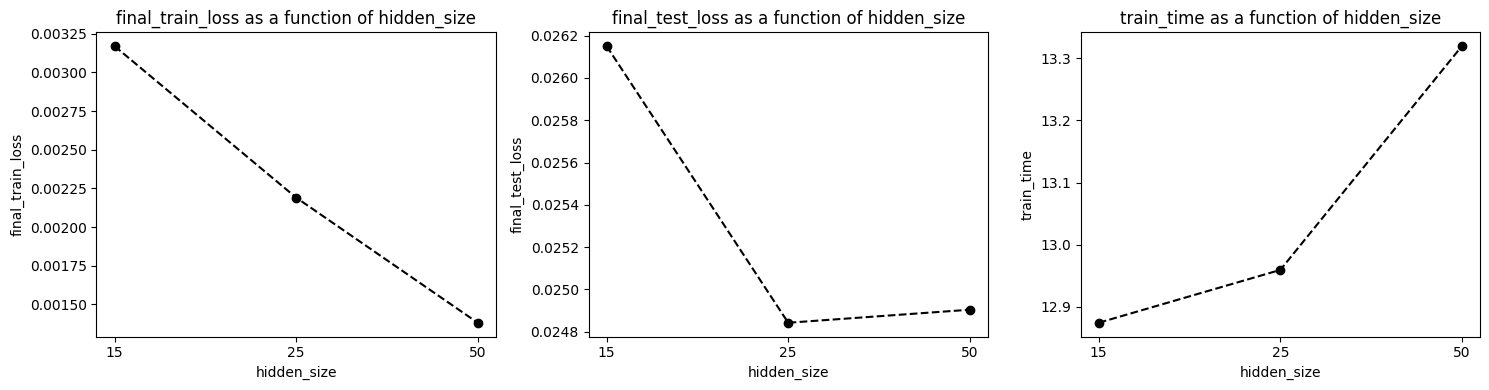

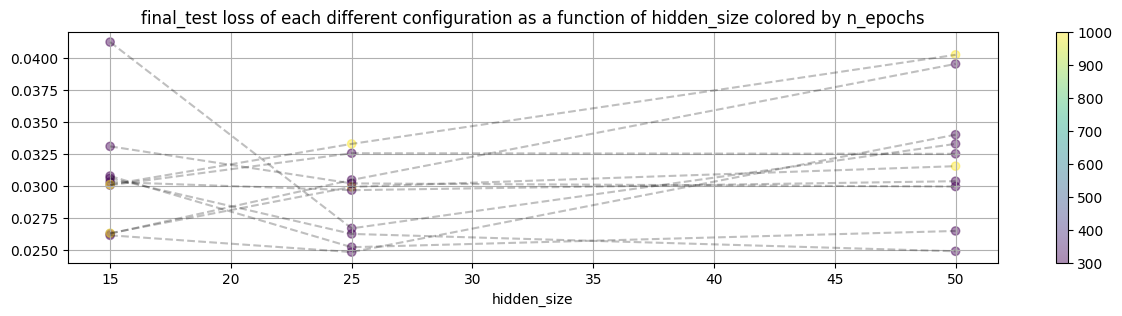

## best configurations for each of the values of hidden_size

,hidden_size,final_test_loss,batch_size,lookback,lr,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
35,25,0.024843,14,28,0.0003,300,1,1,0.013163,"[3.9144759848713875, 2.5019677467644215, 1.355...",15.378506
0,50,0.024904,14,28,0.0001,300,1,1,0.014123,"[9.006186127662659, 8.144149109721184, 7.26710...",21.549169
45,15,0.026150,14,28,0.0003,300,1,1,0.013332,"[10.211043506860733, 8.990259885787964, 7.8442...",15.930560


# lookback

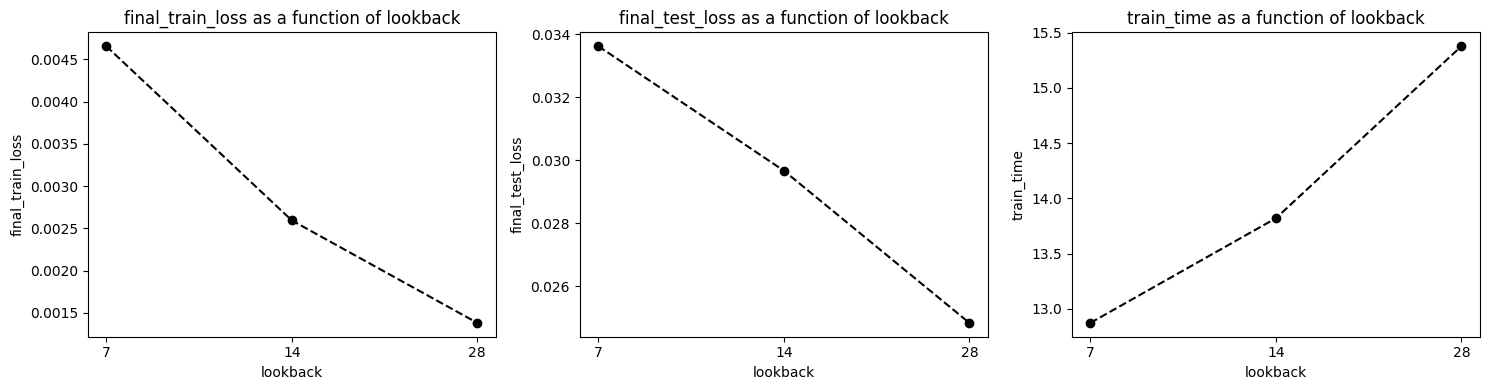

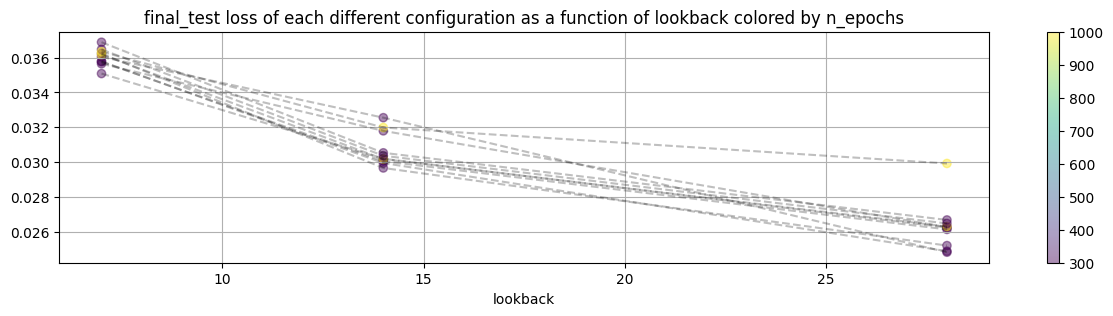

## best configurations for each of the values of lookback

,lookback,final_test_loss,batch_size,hidden_size,lr,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
35,28,0.024843,14,25,0.0003,300,1,1,0.013163,"[3.9144759848713875, 2.5019677467644215, 1.355...",15.378506
40,14,0.029672,14,25,0.0001,300,2,1,0.016096,"[3.764709435403347, 3.2529341876506805, 2.8663...",21.536729
18,7,0.033622,14,50,0.0003,300,3,1,0.015905,"[5.081813730299473, 2.5496003814041615, 1.9477...",30.970449


# lr

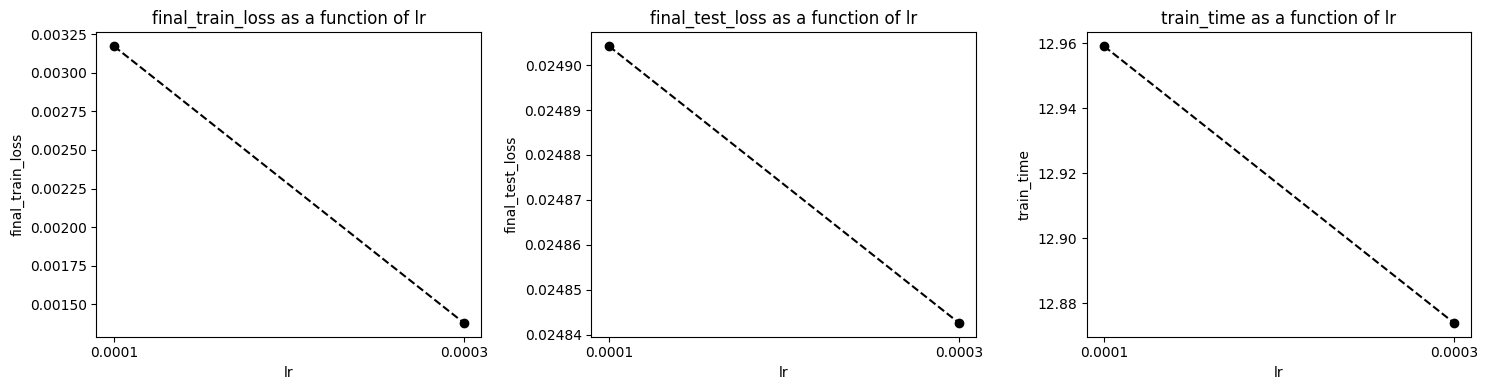

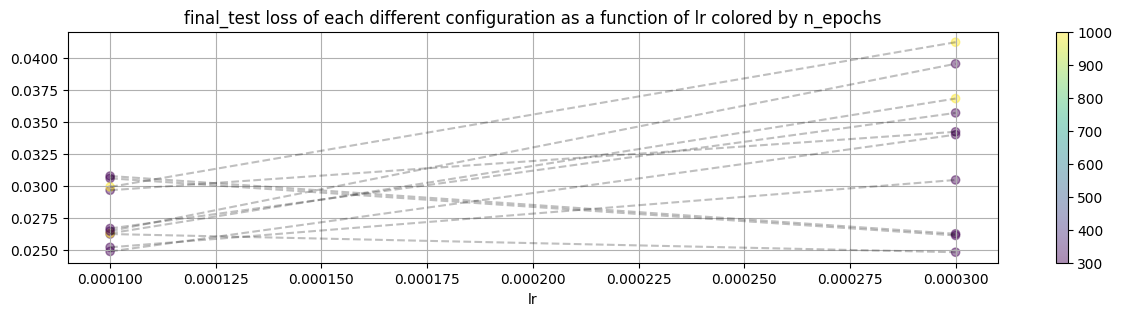

## best configurations for each of the values of lr

,lr,final_test_loss,batch_size,hidden_size,lookback,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
35,0.0003,0.024843,14,25,28,300,1,1,0.013163,"[3.9144759848713875, 2.5019677467644215, 1.355...",15.378506
0,0.0001,0.024904,14,50,28,300,1,1,0.014123,"[9.006186127662659, 8.144149109721184, 7.26710...",21.549169


# n_epochs

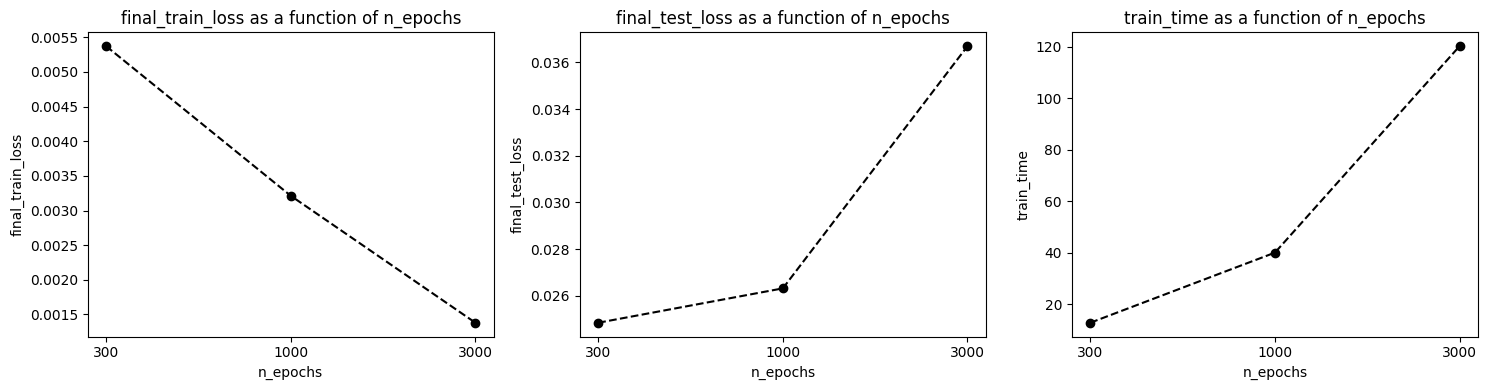

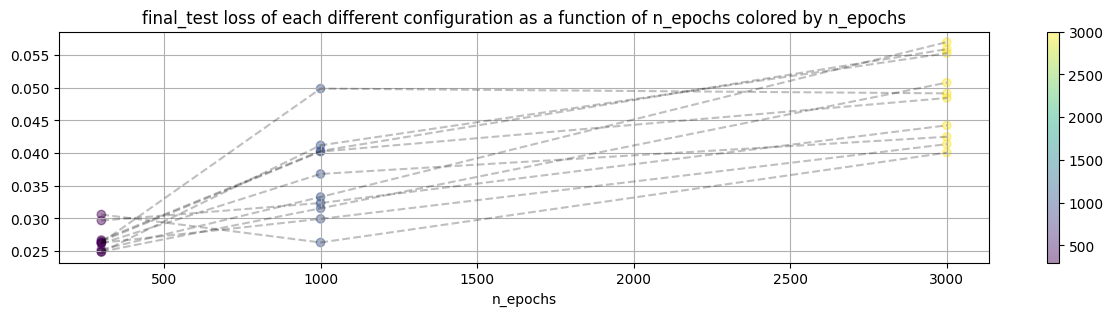

## best configurations for each of the values of n_epochs

,n_epochs,final_test_loss,batch_size,hidden_size,lookback,lr,num_layers,output_size,final_train_loss,train_losses,train_time
35,300,0.024843,14,25,28,0.0003,1,1,0.013163,"[3.9144759848713875, 2.5019677467644215, 1.355...",15.378506
99,1000,0.026316,14,15,28,0.0001,1,1,0.012799,"[3.719280779361725, 3.384024165570736, 3.06705...",51.150678
138,3000,0.036694,14,15,14,0.0001,1,1,0.013482,"[2.8928641602396965, 2.6233287416398525, 2.415...",128.975290


# num_layers

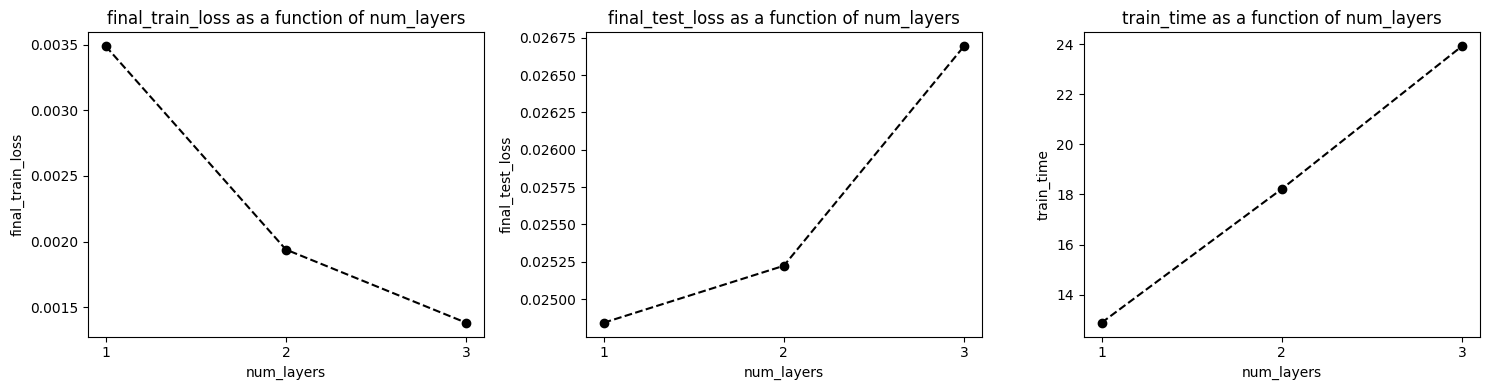

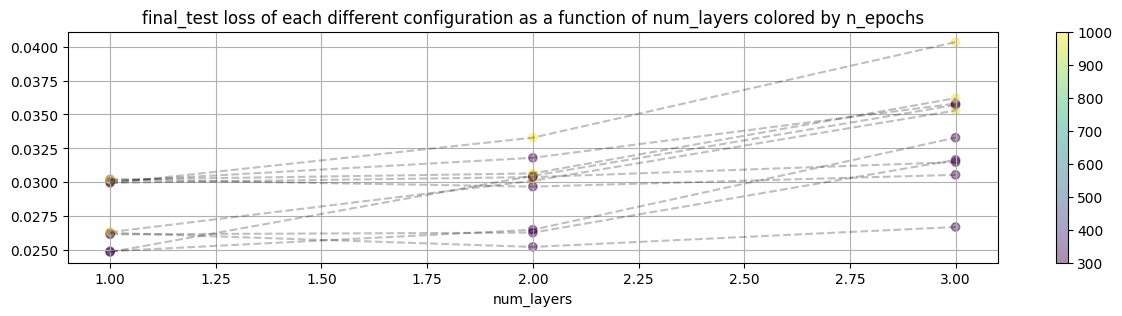

## best configurations for each of the values of num_layers

,num_layers,final_test_loss,batch_size,hidden_size,lookback,lr,n_epochs,output_size,final_train_loss,train_losses,train_time
35,1,0.024843,14,25,28,0.0003,300,1,0.013163,"[3.9144759848713875, 2.5019677467644215, 1.355...",15.378506
21,2,0.025224,14,25,28,0.0001,300,1,0.014517,"[8.466358304023743, 7.582081004977226, 6.69427...",25.116123
15,3,0.026693,14,25,28,0.0001,300,1,0.013979,"[10.37578022480011, 9.021754384040833, 7.58788...",34.098425


In [26]:
do()

In [27]:
best_conf = exps_df.sort_values('final_test_loss').iloc[0].to_dict()
best_conf.pop('train_losses')
best_conf

{'batch_size': 14,
 'hidden_size': 25,
 'lookback': 28,
 'lr': 0.0003,
 'n_epochs': 300,
 'num_layers': 1,
 'output_size': 1,
 'final_train_loss': 0.013162605464458466,
 'final_test_loss': 0.024842604994773865,
 'train_time': 15.378505945205688}

In [140]:
from random import Random
from sklearn.model_selection import ParameterGrid

# Define grid search hyperparameters
grid = ParameterGrid({
    'lookback': [14],
    'output_size': [1],
    'n_epochs': [200, 500],
    'batch_size' : [14],
    'hidden_size': [20, 30],
    'num_layers': [1],
    'lr': [0.0001, 0.0003]
})

grid = list(grid)
Random(42).shuffle(grid)


In [142]:
print("Number of experiments", len(grid))

Number of experiments 8


In [145]:
import pickle as pkl
from tqdm.auto import tqdm

experiments = []
for hyper_params in tqdm(grid):
    experiments.append(evaluate(hyper_params))
    
    with open('experiments.pkl', 'wb') as f:
        pkl.dump(experiments, f)

  0%|          | 0/8 [00:00<?, ?it/s]

In [147]:
!mv experiments.pkl experiments_big2.pkl

In [149]:
with open('experiments_bck2.pkl', 'rb') as f:
    experiments = pkl.load(f)


with open('experiments_bck.pkl', 'rb') as f:
    experiments.extend(pkl.load(f))
    
exps_df = pd.DataFrame(experiments)

# hidden_size

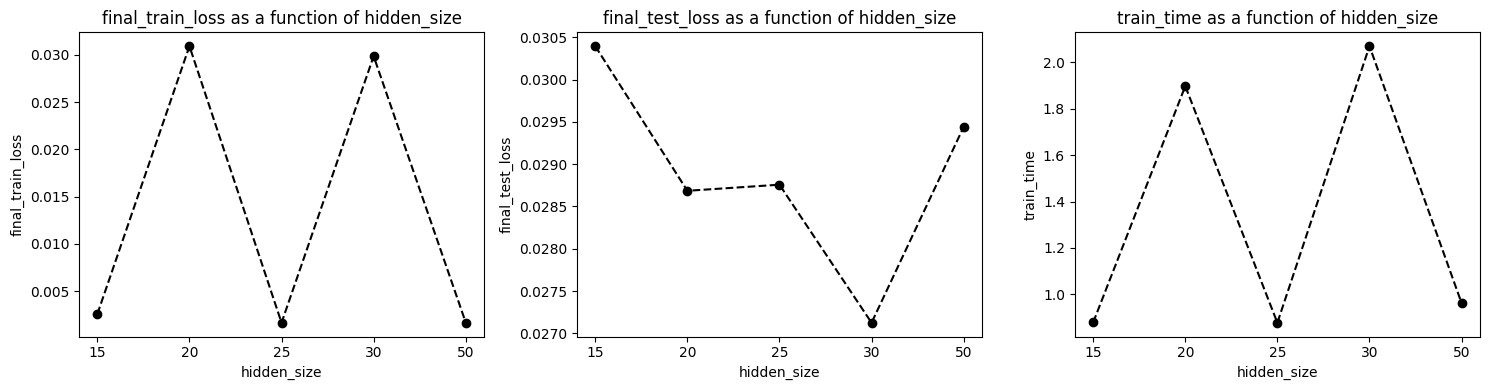

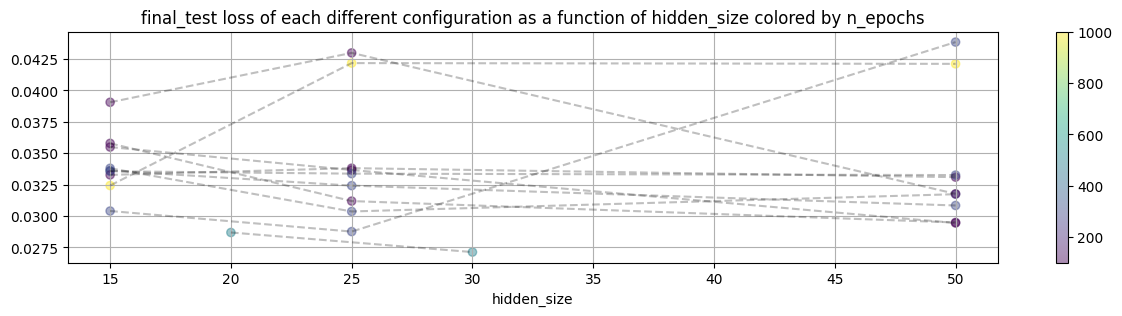

## best configurations for each of the values of hidden_size

,hidden_size,final_test_loss,batch_size,lookback,lr,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
3,30,0.027125,14,14,0.0003,500,1,1,0.029868,"[1.649353563785553, 1.5670530200004578, 1.4674...",5.196921
0,20,0.028686,14,14,0.0003,500,1,1,0.030932,"[1.3437888026237488, 1.2863274663686752, 1.213...",4.767878
82,25,0.028758,14,14,0.0010,300,1,1,0.029210,"[2.3029046058654785, 1.974150151014328, 1.6050...",2.859420
128,50,0.029441,14,14,0.0010,100,1,1,0.031401,"[1.3615199774503708, 0.9961592704057693, 0.679...",1.101101
34,15,0.030396,14,14,0.0010,300,1,1,0.032079,"[5.06883442401886, 4.661237418651581, 4.262247...",3.277933


# lookback

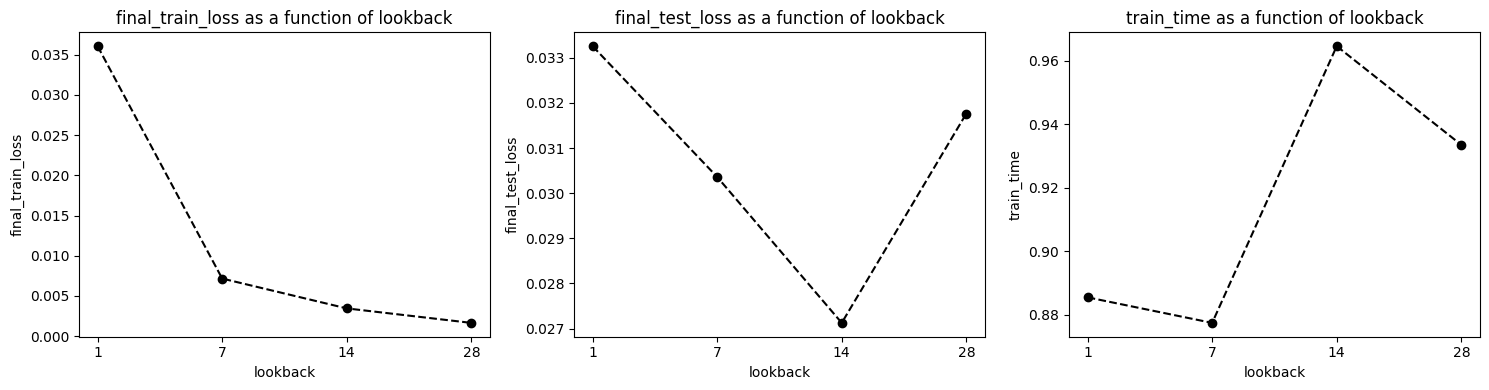

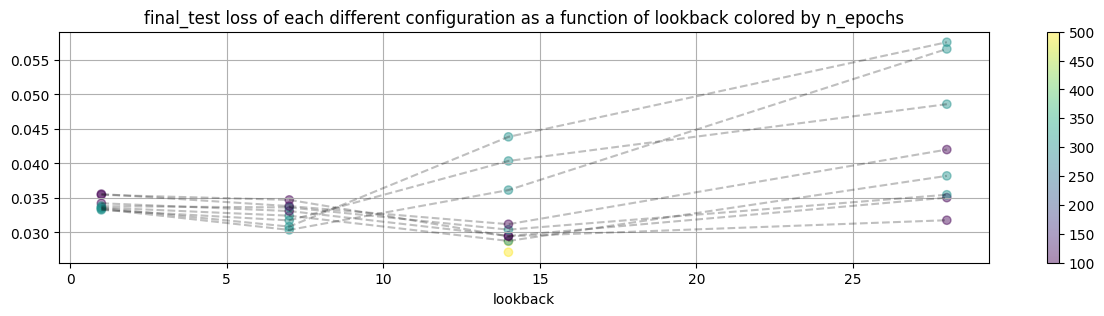

## best configurations for each of the values of lookback

,lookback,final_test_loss,batch_size,hidden_size,lr,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
3,14,0.027125,14,30,0.0003,500,1,1,0.029868,"[1.649353563785553, 1.5670530200004578, 1.4674...",5.196921
71,7,0.030360,14,25,0.0010,300,2,1,0.026896,"[2.131246417760849, 1.7796617448329926, 1.4174...",3.947538
140,28,0.031764,14,50,0.0010,100,1,1,0.030592,"[1.0240801572799683, 0.7789900451898575, 0.575...",1.160483
107,1,0.033258,14,50,0.0010,300,2,1,0.037145,"[2.917640656232834, 2.5757850408554077, 2.2353...",4.298500


# lr

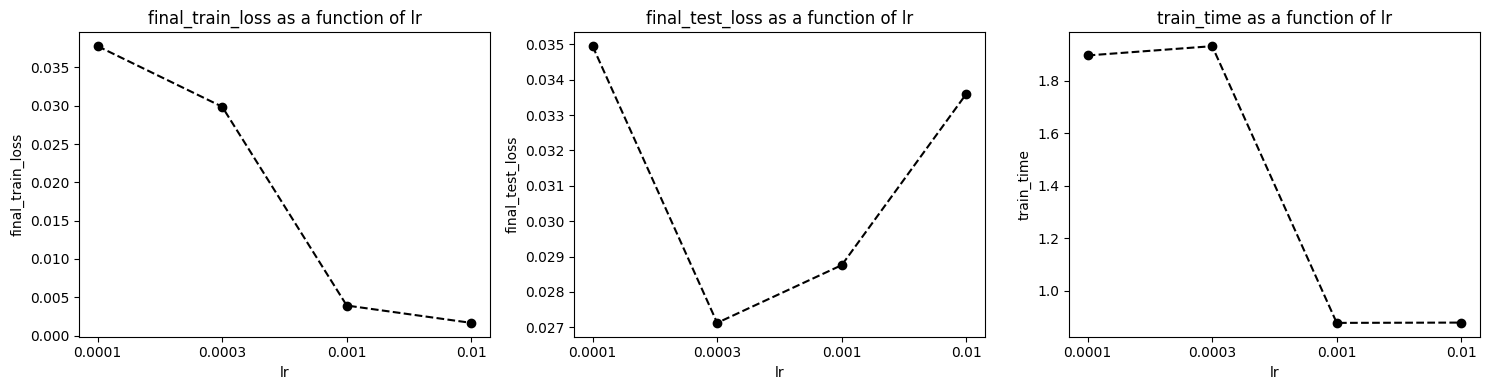

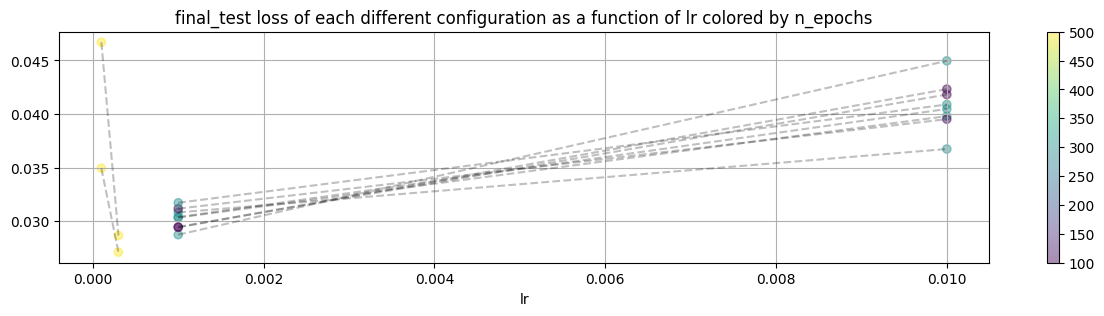

## best configurations for each of the values of lr

,lr,final_test_loss,batch_size,hidden_size,lookback,n_epochs,num_layers,output_size,final_train_loss,train_losses,train_time
3,0.0003,0.027125,14,30,14,500,1,1,0.029868,"[1.649353563785553, 1.5670530200004578, 1.4674...",5.196921
82,0.0010,0.028758,14,25,14,300,1,1,0.029210,"[2.3029046058654785, 1.974150151014328, 1.6050...",2.859420
62,0.0100,0.033598,14,25,1,100,1,1,0.037184,"[2.2237046360969543, 0.6861180812120438, 0.376...",0.885481
5,0.0001,0.034946,14,30,14,500,1,1,0.037773,"[1.674843281507492, 1.6519013941287994, 1.6097...",5.188896


# n_epochs

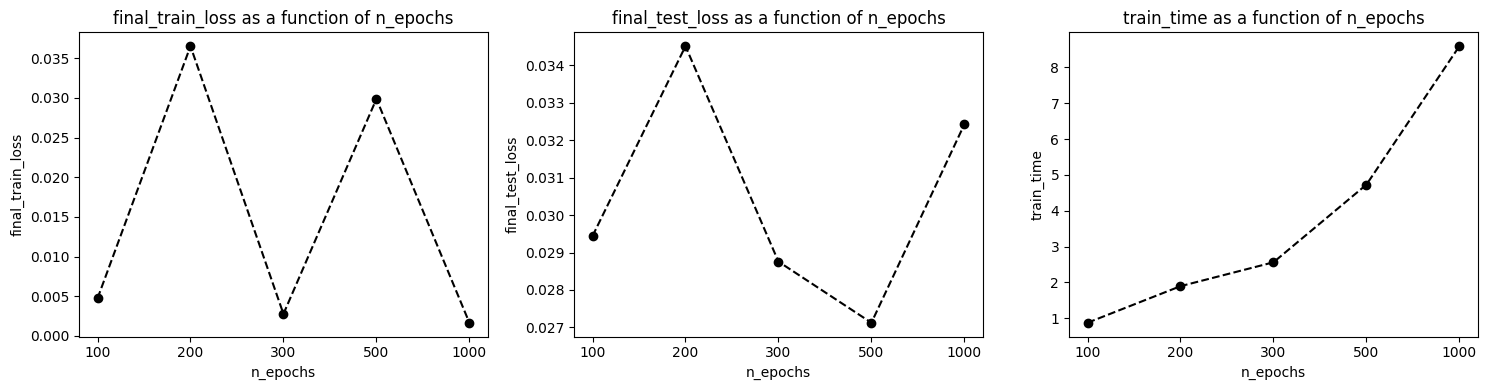

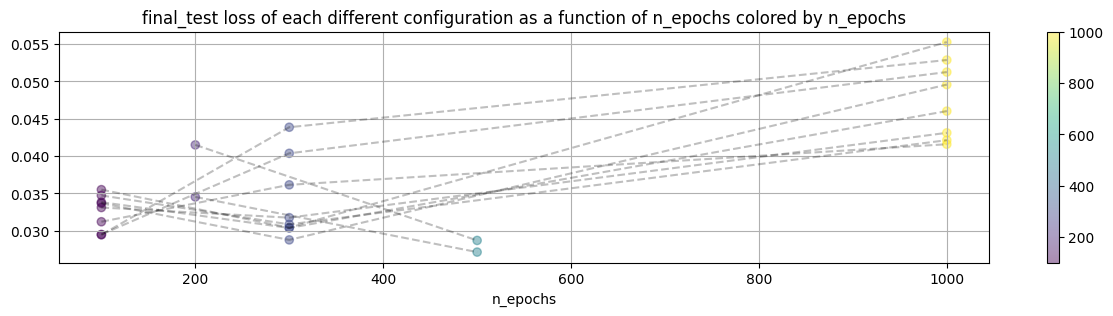

## best configurations for each of the values of n_epochs

,n_epochs,final_test_loss,batch_size,hidden_size,lookback,lr,num_layers,output_size,final_train_loss,train_losses,train_time
3,500,0.027125,14,30,14,0.0003,1,1,0.029868,"[1.649353563785553, 1.5670530200004578, 1.4674...",5.196921
82,300,0.028758,14,25,14,0.0010,1,1,0.029210,"[2.3029046058654785, 1.974150151014328, 1.6050...",2.859420
128,100,0.029441,14,50,14,0.0010,1,1,0.031401,"[1.3615199774503708, 0.9961592704057693, 0.679...",1.101101
24,1000,0.032425,14,15,7,0.0010,1,1,0.026983,"[3.8063257932662964, 3.504287302494049, 3.1485...",8.757516
2,200,0.034512,14,30,14,0.0003,1,1,0.036522,"[1.649353563785553, 1.5670530200004578, 1.4674...",2.069682


# num_layers

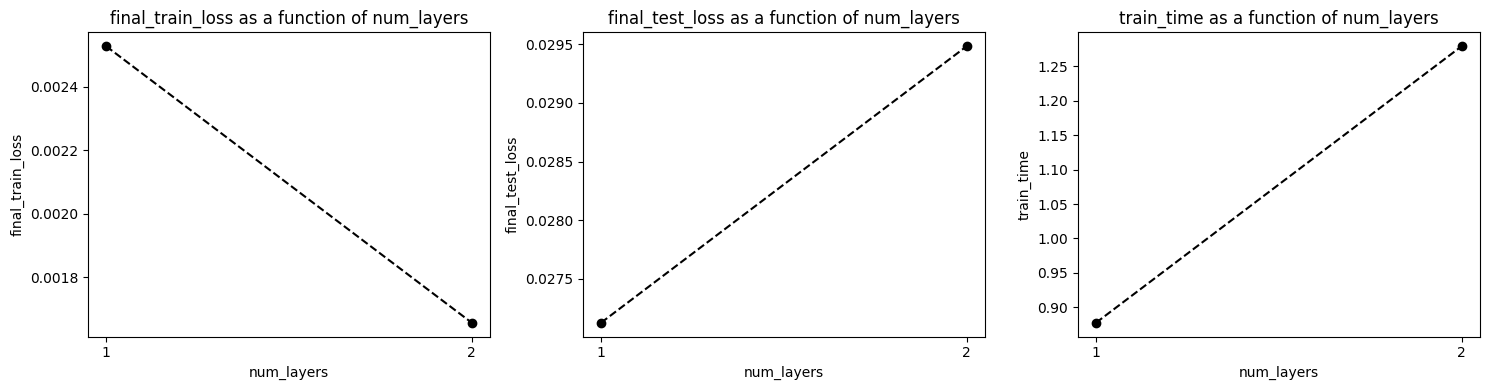

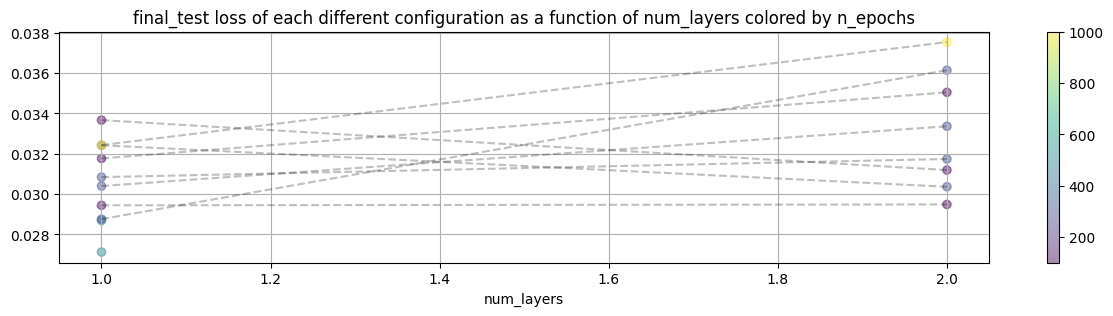

## best configurations for each of the values of num_layers

,num_layers,final_test_loss,batch_size,hidden_size,lookback,lr,n_epochs,output_size,final_train_loss,train_losses,train_time
3,1,0.027125,14,30,14,0.0003,500,1,0.029868,"[1.649353563785553, 1.5670530200004578, 1.4674...",5.196921
129,2,0.029485,14,50,14,0.0010,100,1,0.029875,"[2.307064473628998, 1.558223158121109, 0.83911...",1.832965


In [150]:
do()

In [176]:
best_conf = exps_df.sort_values('final_test_loss').iloc[0].to_dict()
best_conf.pop('train_losses')
best_conf

{'batch_size': 14,
 'hidden_size': 30,
 'lookback': 14,
 'lr': 0.0003,
 'n_epochs': 500,
 'num_layers': 1,
 'output_size': 1,
 'final_train_loss': 0.0298684760928154,
 'final_test_loss': 0.027125000953674316,
 'train_time': 5.196920871734619}

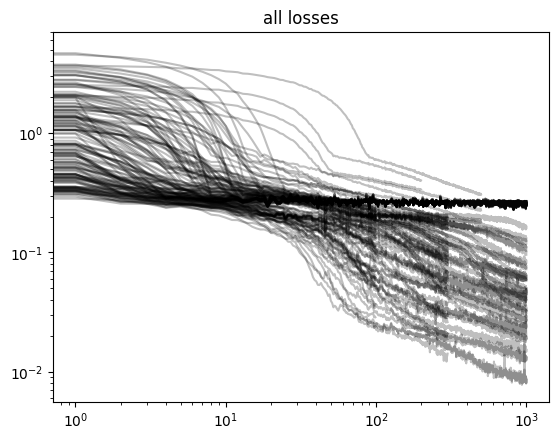

In [178]:
for cfg in exps_df.to_dict(orient='records'):
    plt.loglog(cfg['train_losses'], 'k', alpha=0.25)
    plt.title("all losses")
    
